In [41]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import yasa
from scipy.signal import welch
import seaborn as sns
from scipy.signal import welch, freqz, butter, filtfilt
from mne.decoding import CSP

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB

In [22]:
fs = 100
low = 7
high = 30

events = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_mrk.txt', header=None, sep='\t')
events = np.squeeze(events.values.tolist())

# Import all the electrodes 
electrodes_all = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_nfo.txt', header=None, delimiter=', ', nrows=1, engine='python')
electrodes_all = np.squeeze(electrodes_all.values.tolist())

# use the electrodes that span the motor cortex
first_electrode = np.where(electrodes_all=='CFC7')[0][0]
last_electrode = np.where(electrodes_all=='CCP8')[0][0]

electrodes25 = electrodes_all[first_electrode:last_electrode+1]

C1_ind25 = np.where(electrodes25=='C1')[0][0]
C2_ind25 = np.where(electrodes25=='C2')[0][0]
C3_ind25 = np.where(electrodes25=='C3')[0][0]
C4_ind25 = np.where(electrodes25=='C4')[0][0]
Cz_ind25 = np.where(electrodes25=='Cz')[0][0]

C1_ind = np.where(electrodes_all=='C1')[0][0]
C2_ind = np.where(electrodes_all=='C2')[0][0]
C3_ind = np.where(electrodes_all=='C3')[0][0]
C4_ind = np.where(electrodes_all=='C4')[0][0]
Cz_ind = np.where(electrodes_all=='Cz')[0][0]

data = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_cnt.txt', names=electrodes_all, delimiter='\t')
data = data.to_numpy()

In [23]:
def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch

In [24]:
Cz = data[:, Cz_ind]
C1_cz = data[:, C1_ind] - Cz #Cz reference has been the best!
C2_cz = data[:, C2_ind] - Cz
C3_cz = data[:, C3_ind] - Cz
C4_cz = data[:, C4_ind] - Cz

selected_electrodes = (np.vstack((C3_cz, C4_cz))).T
channels = selected_electrodes.shape[1]

print(selected_electrodes.shape)


(210259, 2)


{False, True}


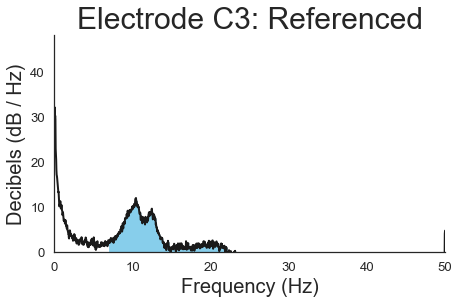

In [25]:
freqs, psd = plot_spectrum(C3_cz, fs, (32), [1, 50], dB=True)

# Define mu band
# Find intersecting values in frequency vector
idx_mu = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Referenced", fontsize=30)
sns.despine()

print(set(freqs == 7))

In [26]:
start = events[0][0]
zeros = 50 # Lower resolution work best
sec = 1

C3_t1 = C3_cz[start: start + int(sec*fs)]
C3_t1_pad = np.pad(C3_t1, [(zeros, zeros)], mode='constant')

freqs, psd = plot_spectrum(C3_t1_pad, fs, (32), [1, 50], dB=True)
print(freqs)

low_ind = np.where(freqs == low)[0][0]
high_ind = np.where(freqs == high)[0][0]

psd_sliced = psd[low_ind: high_ind]
freqs_sliced = freqs[low_ind: high_ind]
print(psd_sliced)

n_freqs = len(psd_sliced)
print("Number of frequencies per electrode: ", n_freqs)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50. ]
[  4.15950687   3.08375891   1.07720074   0.30078132   4.74093122
   5.54866255   8.37482878   3.51051246  -0.47703676   5.74046491
   5.13043928   0.43805076  -2.21125534  -0.12622564  -0.73271347
   2.72254213   4.19212738   1.37349314  -4.57571451  -0.39419534
   1.4023162   -2.54644227  -8.4343576  -14.06694197   0.42688034
   0.38334179  -0.83855874   1.72227453  -8.42420914  -0.30082832
   7.21255951   7.30420524   5.28182243   5.67036756  -4.10960772
 -11.70418134  -2.349690

/opt/miniconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 3200 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


In [27]:
# Take in a trial of size [channels, samples] and spit out the feature vector
# Feature vector is the frequencies of each channel concatenated

def psd_of_window(trial, n_freqs, zeros, fs, low, high):
    channels = trial.shape[1]
    temp = np.zeros((channels, n_freqs))
    
    for j in range(channels):
        trial_pad = np.pad(trial[:, j], [(zeros, zeros)], mode='constant')
        freqs, psd = plot_spectrum(trial_pad, fs, (32), [low, high], dB=True)

        low_ind = np.where(freqs == low)[0][0]
        high_ind = np.where(freqs == high)[0][0]

        psd_sliced = psd[low_ind: high_ind]
        freqs_sliced = freqs[low_ind: high_ind]

        temp[j, :] = psd_sliced

    return np.ravel(temp)

In [28]:
# Create training data

def create_data(data, fs, low, high, n_freqs, trials, sec, gap, gap2, zeros):
    channels = data.shape[1]
    y = []
    rest_row = 0
    x = np.zeros((trials*2, channels*n_freqs))
    temp = np.zeros((channels, n_freqs))
    rest = np.zeros((trials, channels*n_freqs))
    print(x.shape, temp.shape)
    
    win = round(sec*fs)
    rest_row = 0
    for i in range(0, trials*2, 2):
        event = events[int(i/2)]

        y.append(1)
        y.append(0)
            
        # Take 2 sec window 1 second after motor imagery onset
        all_channel_trial = data[event[0]+fs:event[0]+fs+fs+win, :]
        x[i, :] = psd_of_window(all_channel_trial, n_freqs, 0, fs, low, high)
        
        # Take 1 sec window of rest after 0.75s motor imagery ends
        all_channel_trial = data[event[0]+int((3.5+gap)*fs):event[0]+int((3.5+gap+sec)*fs), :]
        x[i+1, :] = psd_of_window(all_channel_trial, n_freqs, zeros, fs, low, high)
    
    return x, y
    

X, y = create_data(selected_electrodes, fs, low, high, n_freqs, 210, 1, 0.75, 1, zeros) 
print(X.shape, len(y))
# print(X)
print(y)
# 0: 1Hz res
# 50: 0.5Hz res
# 150: 0.25Hz res
# 450: 0.1Hz res

(420, 92) (2, 46)
(420, 92) 420
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1

In [33]:
# Take the last 210 trials as test data
# Do not shuffle, we need this to be temporally accurate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

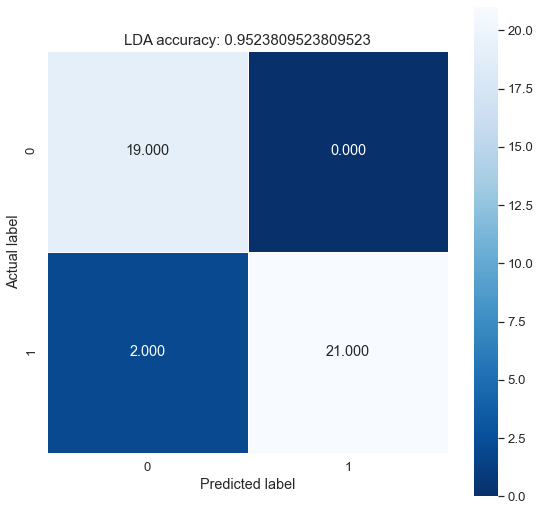

In [34]:
from sklearn.metrics import accuracy_score

model = LDA(shrinkage='auto', solver='eigen')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_pred, y_test)
score = accuracy_score(y_pred, y_test)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'LDA accuracy: {1}'.format("", score)
plt.title(all_sample_title, size = 15);

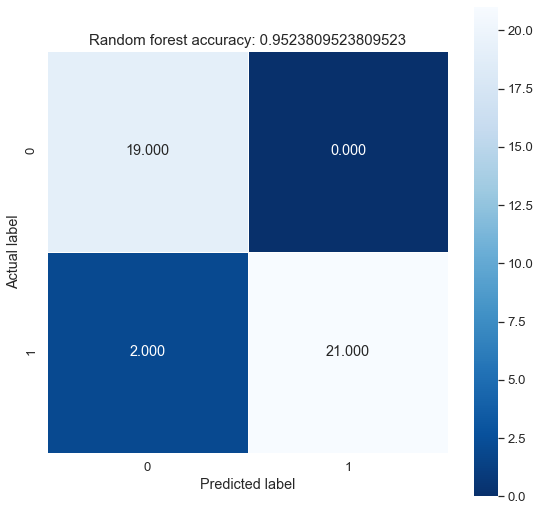

In [35]:
model = rfc(n_estimators=300)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_pred, y_test)
score = accuracy_score(y_pred, y_test)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random forest accuracy: {1}'.format("", score)
plt.title(all_sample_title, size = 15);

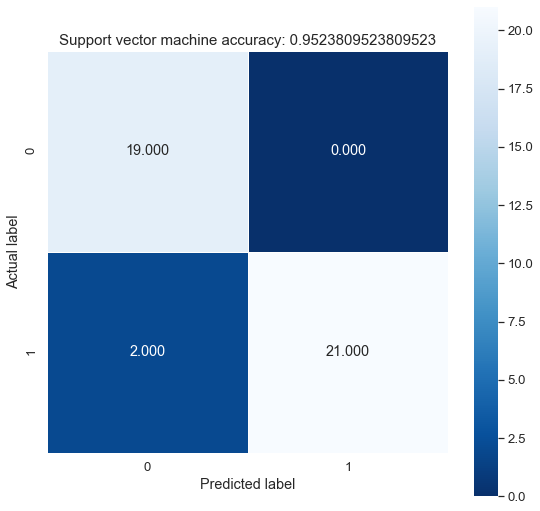

In [36]:
model = SVC(kernel='rbf')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_pred, y_test)
score = accuracy_score(y_pred, y_test)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Support vector machine accuracy: {1}'.format("", score)
plt.title(all_sample_title, size = 15);

# Real time (asynchronous) prediction

Take a trial that starts -1s before motor imagery onset and 1.5s after motor imagery finishes. So the 3.5s motor imagery period starts and ends with rest. 

Take a 1 sec sliding window and slide it across 1 sample at a time and output a prediction of rest, left hand or right foot.

Smoothen the prediction to acquire a 'confidence' score or motor imagery scale

In [37]:
model = LDA(shrinkage='auto', solver='eigen')
model_trained = model.fit(X_train, y_train)

In [38]:
def predict_stuff(trial, model):
    output = []
    a = 0
    b = 100
    inc = 1
    
    while (b < trial.shape[0]):
        win = trial[a:b, :]
        features = psd_of_window(win, n_freqs, zeros, fs, low, high)
        features = features.reshape(1, -1)
        output.append(model.predict(features))
        
        a += 1
        b += 1
    
    return output

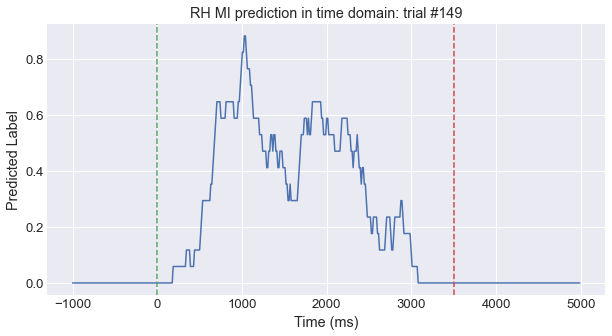

In [45]:
from scipy.signal import savgol_filter

def plot_MI_predictions(model, stp, ind):
    output = []
    a = 0
    b = 100
    
    start = events[ind][0]
    trial = selected_electrodes[start-100:start+500, :]
    
    while (b < trial.shape[0]):
        win = trial[a:b, :]
        
        features = psd_of_window(win, n_freqs, zeros, fs, low, high)
        features = np.reshape(features, (1, -1))
        
        # Only use classifier output if probability is greater than threshold
        if max(model.predict_proba(features)[0]) > 0.8:
            output.append(model.predict(features)[0])
        else:
            output.append(0)
        
        a += int(stp/10)
        b += int(stp/10)
        
    smoothed = savgol_filter(output, 17, 1)
    
    interval_size = int((trial.shape[0] - 100)/int(stp/10))
    time = range(-1000, 5000, int(6000/interval_size))

    sns.set(font_scale=1.2, style='white')
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(10, 5))
    plt.plot(time, smoothed)
    plt.xlabel('Time (ms)')
    plt.ylabel('Predicted Label')
    plt.axvline(x=0, linestyle='dashed', color='g')
    plt.axvline(x=3500, linestyle='dashed', color='r')
    
    if (events[ind][1] == 1):
        MI_type = "RH"
    else:
        MI_type = "LH"
    
    if (ind != None):
        plt.title(MI_type + " " + "MI prediction in time domain: " + "trial #"  + str(ind+1))
    else:
        plt.title("MI prediction in time domain")
    
    plt.savefig('Graphs/predictions/LDA/2Class/Trial ' + '#' + str(ind+1))
    sns.despine()
    
    return smoothed, output

smoothed, output = plot_MI_predictions(model_trained, 10, 148) # stp is in ms!

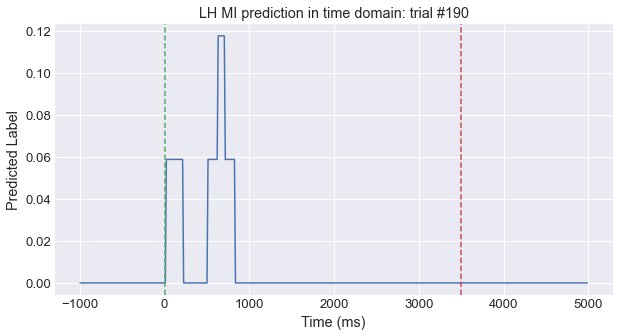

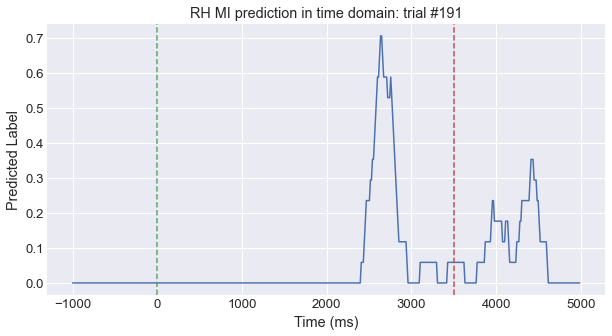

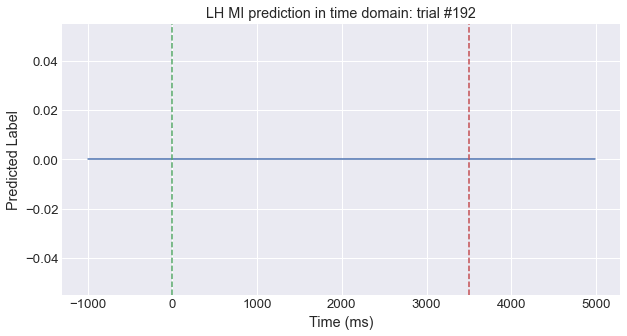

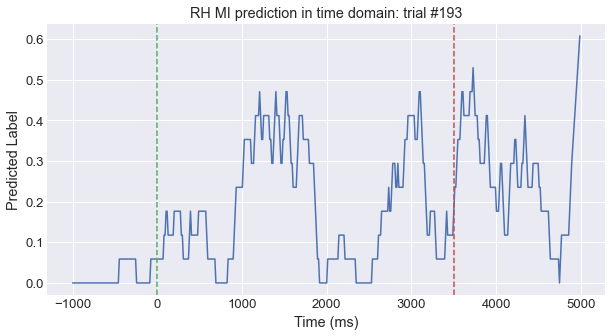

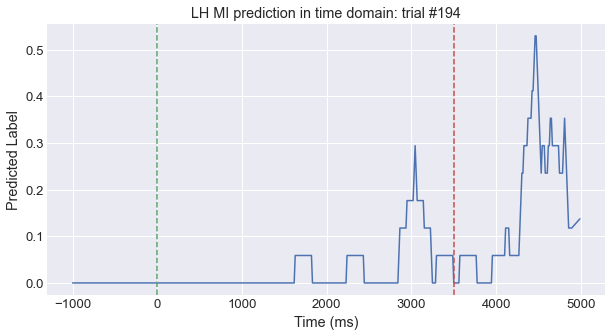

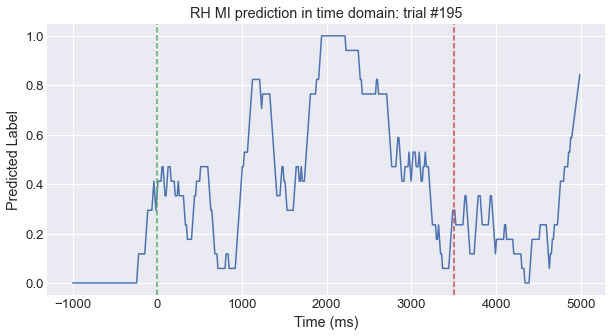

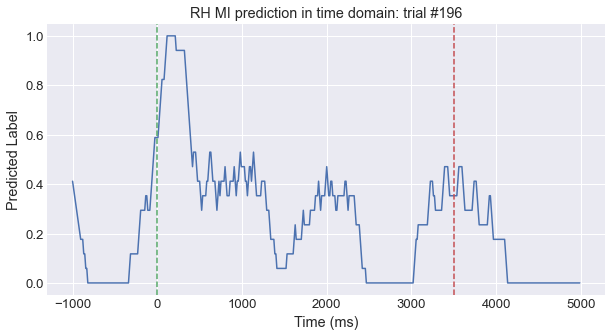

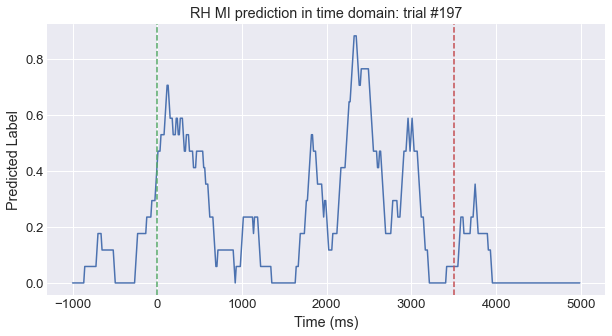

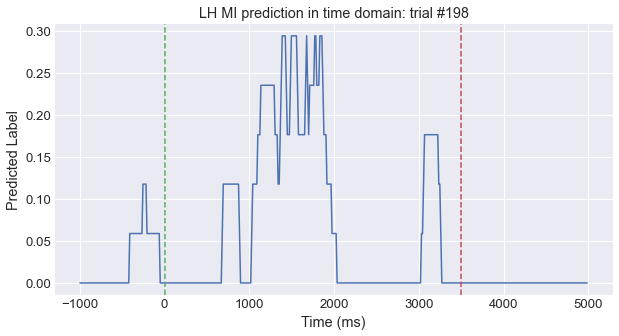

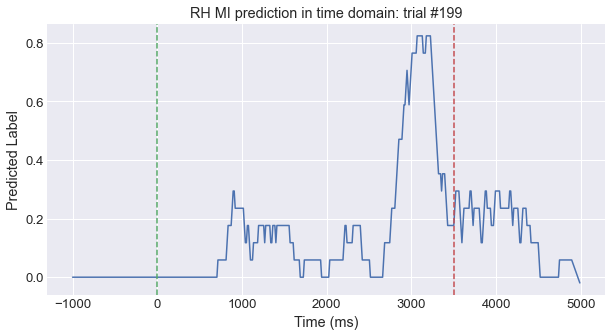

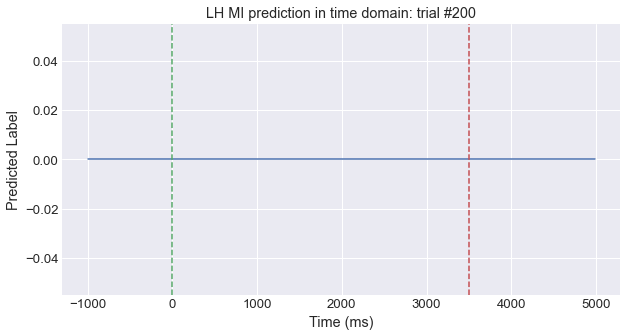

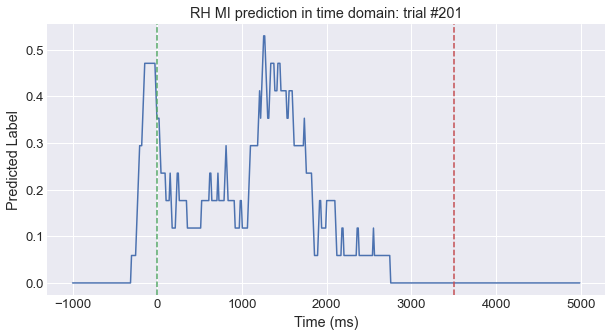

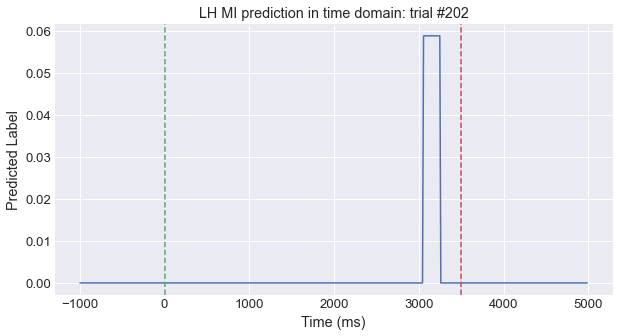

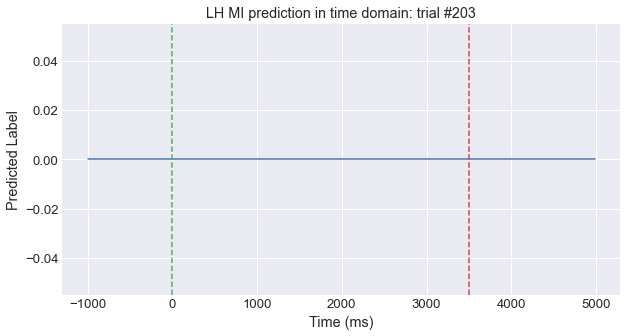

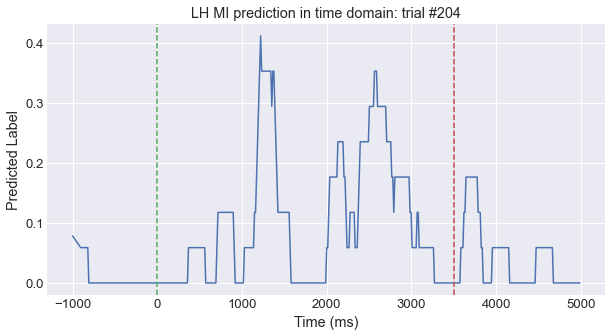

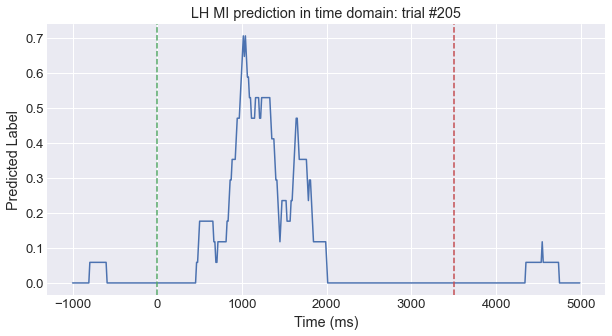

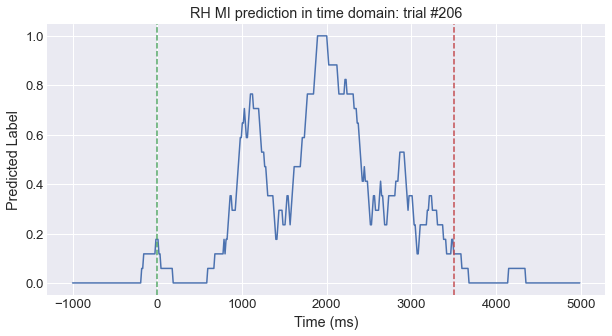

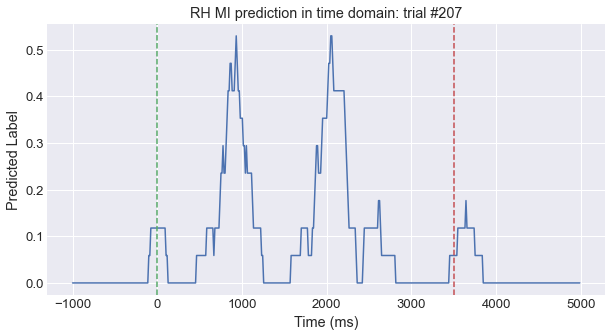

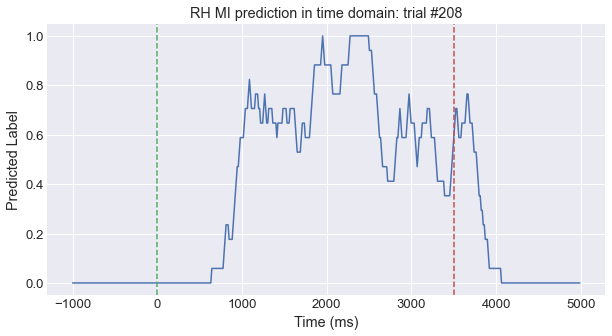

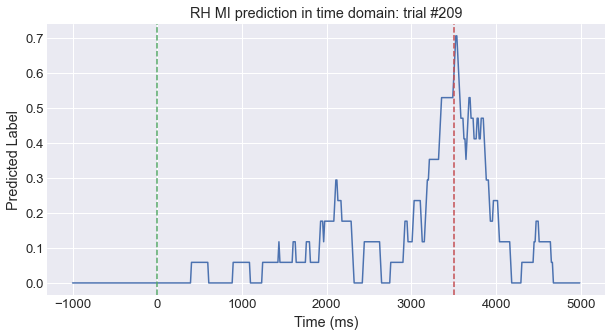

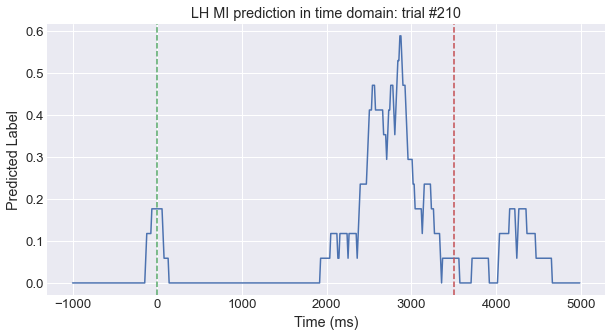

In [46]:
def plot_MI_trials(ind_start, model_trained, stp):
    all_smoothed = []
    all_output = []
    for i in range(ind_start, 210):
        start = events[i][0]
        smoothed, output = plot_MI_predictions(model_trained, stp, i) # stp is in ms
        all_smoothed.append(smoothed)
        all_output.append(output)
    return np.array(all_smoothed), np.array(all_output)
        
all_smoothed, all_output = plot_MI_trials(int(0.9*210), model_trained, 10)

(500,)


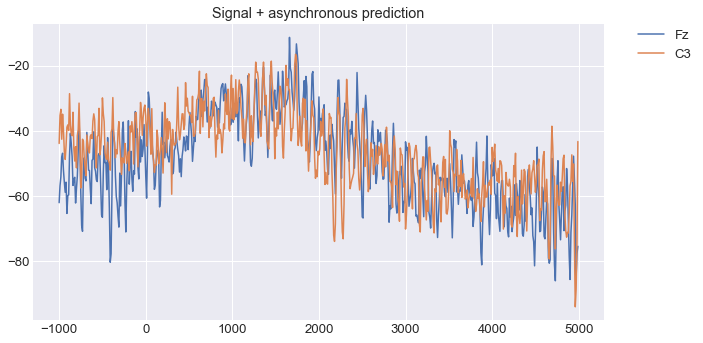

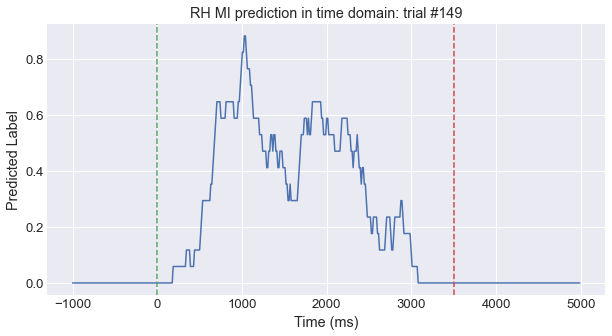

In [47]:
trial_149 = selected_electrodes[events[148][0]-100:events[148][0]+500]
time = range(-1000, 5000, 10)

sns.set(font_scale=1.2, style='white')
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(time, trial_149)
plt.title("Signal + asynchronous prediction")
plt.legend(['Fz', 'C3', 'C4', 'Pz', 'PO7', 'Pz', 'PO8'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) 
plt.tight_layout()

smoothed, output = plot_MI_predictions(model, 10, 148) # stp is in ms
print(smoothed.shape)